In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid1719696/


In [2]:
from astropy.io import fits
import os
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pyhalofit
import pandas as pd
import gc
import healpy as hp

import sys
sys.path.insert(0, '../skylens')
sys.path.insert(0, '../hscy1/3_meas_vs_theory')
from wl.ximod import *
from wigner_transform import *
import correction
import treecorr
import pyccl
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_taper(l=[],
        large_l_lower=1000,
        large_l_upper=1500,
        low_l_lower=10,
        low_l_upper=50,):
    taper_f = np.zeros_like(l, dtype="float64")
    x = l > large_l_lower
    taper_f[x] = np.cos(
        (l[x] - large_l_lower) / (large_l_upper - large_l_lower) * np.pi / 2.0
    )
    x = np.logical_and(l <= large_l_lower, l >= low_l_upper)
    taper_f[x] = 1
    x = l < low_l_upper
    taper_f[x] = np.cos(
        (l[x] - low_l_upper) / (low_l_upper - low_l_lower) * np.pi / 2.0
    )

    x = np.logical_or(l <= low_l_lower, l >= large_l_upper)
    taper_f[x] = 0
    taper_f = {"taper_f": taper_f, "l": l}
    return taper_f

In [4]:
ell = np.arange(5000)

In [31]:
theta = np.loadtxt('../2pcf_800/r000_rot00/cf_0_0.txt')[:, 0]/60
taper = get_taper(theta, low_l_lower=theta[0], low_l_upper=30/60, large_l_lower=130/60, large_l_upper=theta[-1])
xi_t = taper['taper_f']
xi_t[0] = 0
xi_t[-1] = 0
WT = wigner_transform(theta=theta*d2r, l=ell, s1_s2=[(0, 0), (2, 2), (2, -2)])
WT.gather_data()
s = s1_s2s[corr_ll]
l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=theta*d2r,wig_theta=theta*d2r,xi=xi_t,
                                          s1_s2=s,wig_d=WT.wig_d[(0, 0)].T,wig_norm=WT.inv_wig_norm)
l_inv_th,wl_inv_p_th=WT.inv_projected_correlation(theta_xi=theta*d2r,wig_theta=theta*d2r,xi=np.ones_like(xi_t),
                                          s1_s2=s,wig_d=WT.wig_d[(0, 0)].T,wig_norm=WT.inv_wig_norm)

Scattering WT data 1


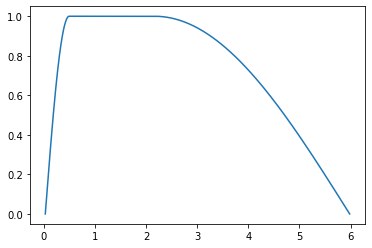

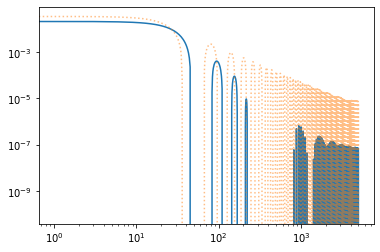

In [32]:
plt.plot(theta, xi_t);
plt.figure()
plt.loglog(l_inv, wl_inv)
plt.loglog(l_inv_th, wl_inv_p_th, ':', alpha=0.5)

In [33]:
ell = np.arange(5000)
l = sorted(glob.glob('../2pcf_800/r*'))[:20]
N = len(l)

cf_dict = dict()
cf_keys = ['correction']
for cf_key in cf_keys:
    cf_dict[cf_key] = np.zeros((N, 4, 800, 2))
cf_data = dict()

for i in tqdm(range(N)):
    file = l[i]
    run, rot = file[13:16], file[20:22]
    run = int(run)
    rot = int(rot)
    cf_data[i] = np.zeros((4, 800, 2))
    for j in range(4):
        cf_name = f'{file}/cf_{j}_{j}.txt'
        for cf_key in cf_keys:
            if cf_key == 'ccl': cl_fname = f'../cl_ccl/r{run:03d}_rot{rot:02d}/cl_{j}_{j}.txt'
            else: cl_fname = f'../cl_corrected/r{run:03d}_rot{rot:02d}/cl_{j}_{j}.txt'
            cl = pd.read_csv(cl_fname, nrows=5000, header=None, sep=' ', usecols=[1]).values.squeeze()
            cf_dict[cf_key][i][j][:, 0] = WT.projected_correlation(ell, cl, s1_s2=(2, 2))[1]
            cf_dict[cf_key][i][j][:, 1] = WT.projected_correlation(ell, cl, s1_s2=(2, -2))[1]
        cf_data[i][j] = pd.read_csv(cf_name, nrows=800, header=None, sep=' ', usecols=[1, 2]).values.squeeze()
        cf_data[i][j, :, 0] *= xi_t
        cf_data[i][j, :, 1] *= xi_t

100%|██████████| 20/20 [00:02<00:00,  6.96it/s]


In [34]:
cf_data_np = np.zeros((N, 4, 800, 2))

for i in range(N):
    for j in range(2):
        cf_data_np[i][:, :, j] = cf_data[i][:, :, j]
cf_data_avg = np.mean(cf_data_np, axis=0)

In [35]:
cf_avg = dict()
for cf_key in cf_keys:
    cf_avg[cf_key] = np.mean(cf_dict[cf_key], axis=0)

In [36]:
cf_colors = {'ccl': 'C1', 'correction': 'C2'}
cf_labels = {'ccl': 'CCL', 'correction': 'Res+Shell Correction'}
cf_dots = {'ccl': 'p', 'correction': 's'}

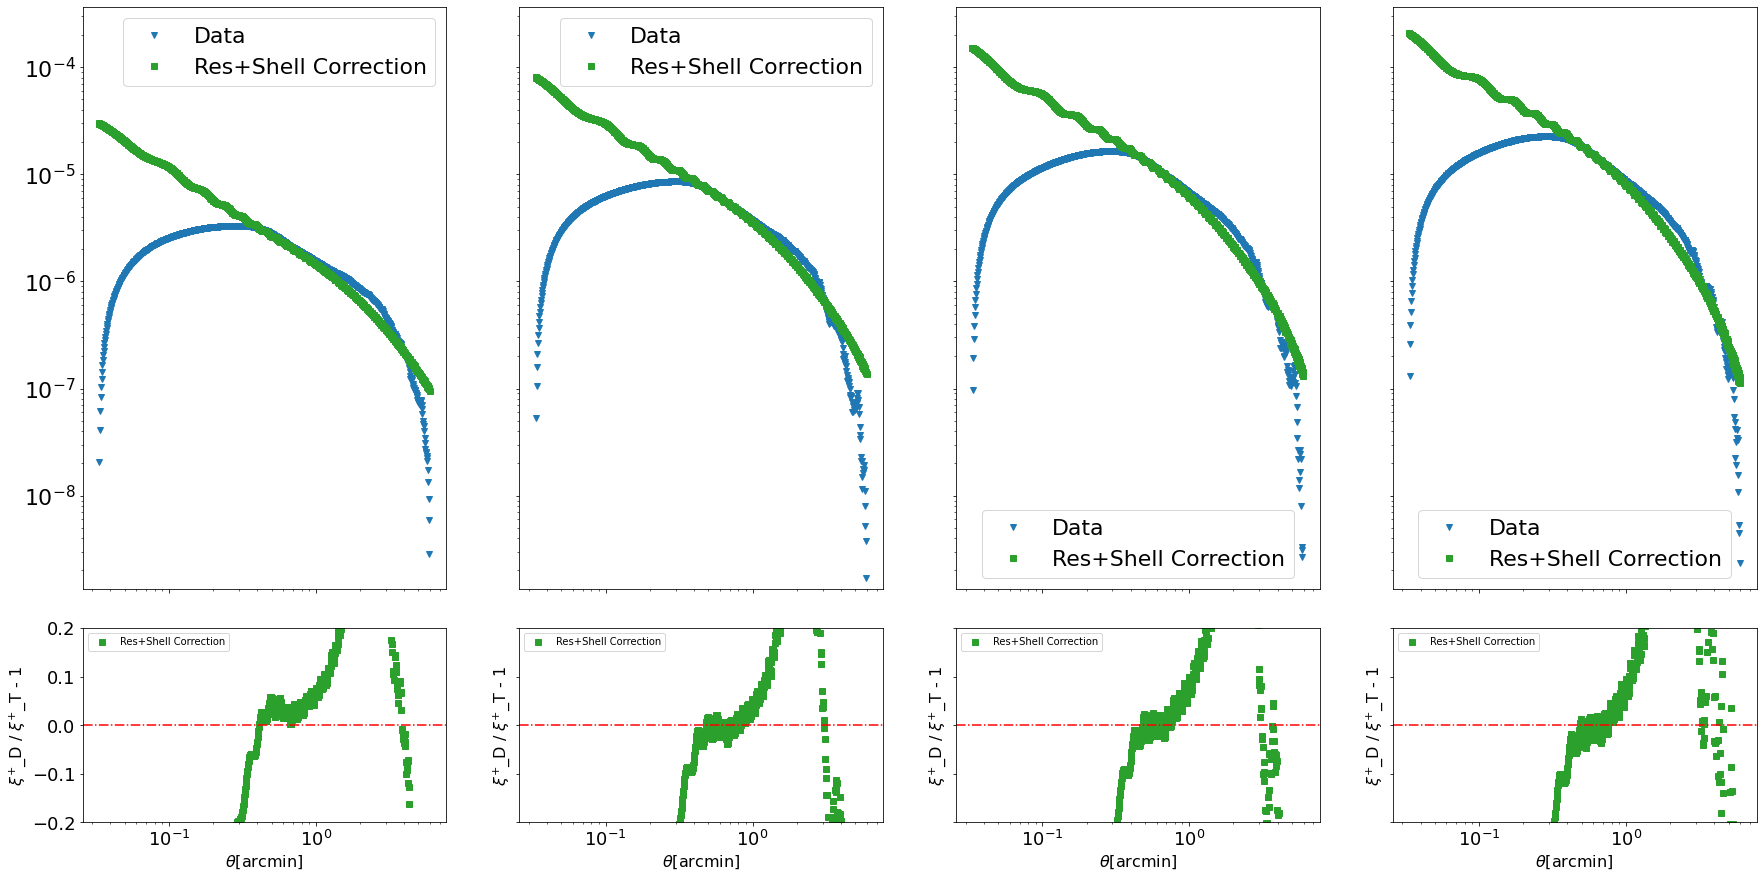

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 15), sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
for i in range(4):
    top, bot = axs[0, i], axs[1, i]
    top.loglog(theta, cf_data_avg[i, :, 0], 'v', label='Data')
    for cf_key in cf_keys:
        top.loglog(theta, cf_avg[cf_key][i, :, 0], cf_dots[cf_key], label=cf_labels[cf_key], color=cf_colors[cf_key])
        bot.semilogx(theta, cf_data_avg[i, :, 0] / cf_avg[cf_key][i, :, 0] - 1, cf_dots[cf_key], label=cf_labels[cf_key], color=cf_colors[cf_key])
        
    top.legend(fontsize=22)
    top.tick_params(axis='both', which='major', labelsize=22)
    top.tick_params(axis='both', which='minor', labelsize=10)
    bot.legend()
    bot.set_xlabel(r'$\theta$[arcmin]', fontsize=16)
    bot.set_ylabel(r'$\xi^{+}$_D / $\xi^{+}$_T - 1', fontsize=16)
    bot.tick_params(axis='both', labelsize=18)
    bot.set_ylim(-0.2, 0.2)
    bot.axhline(0, c='red', ls='-.')

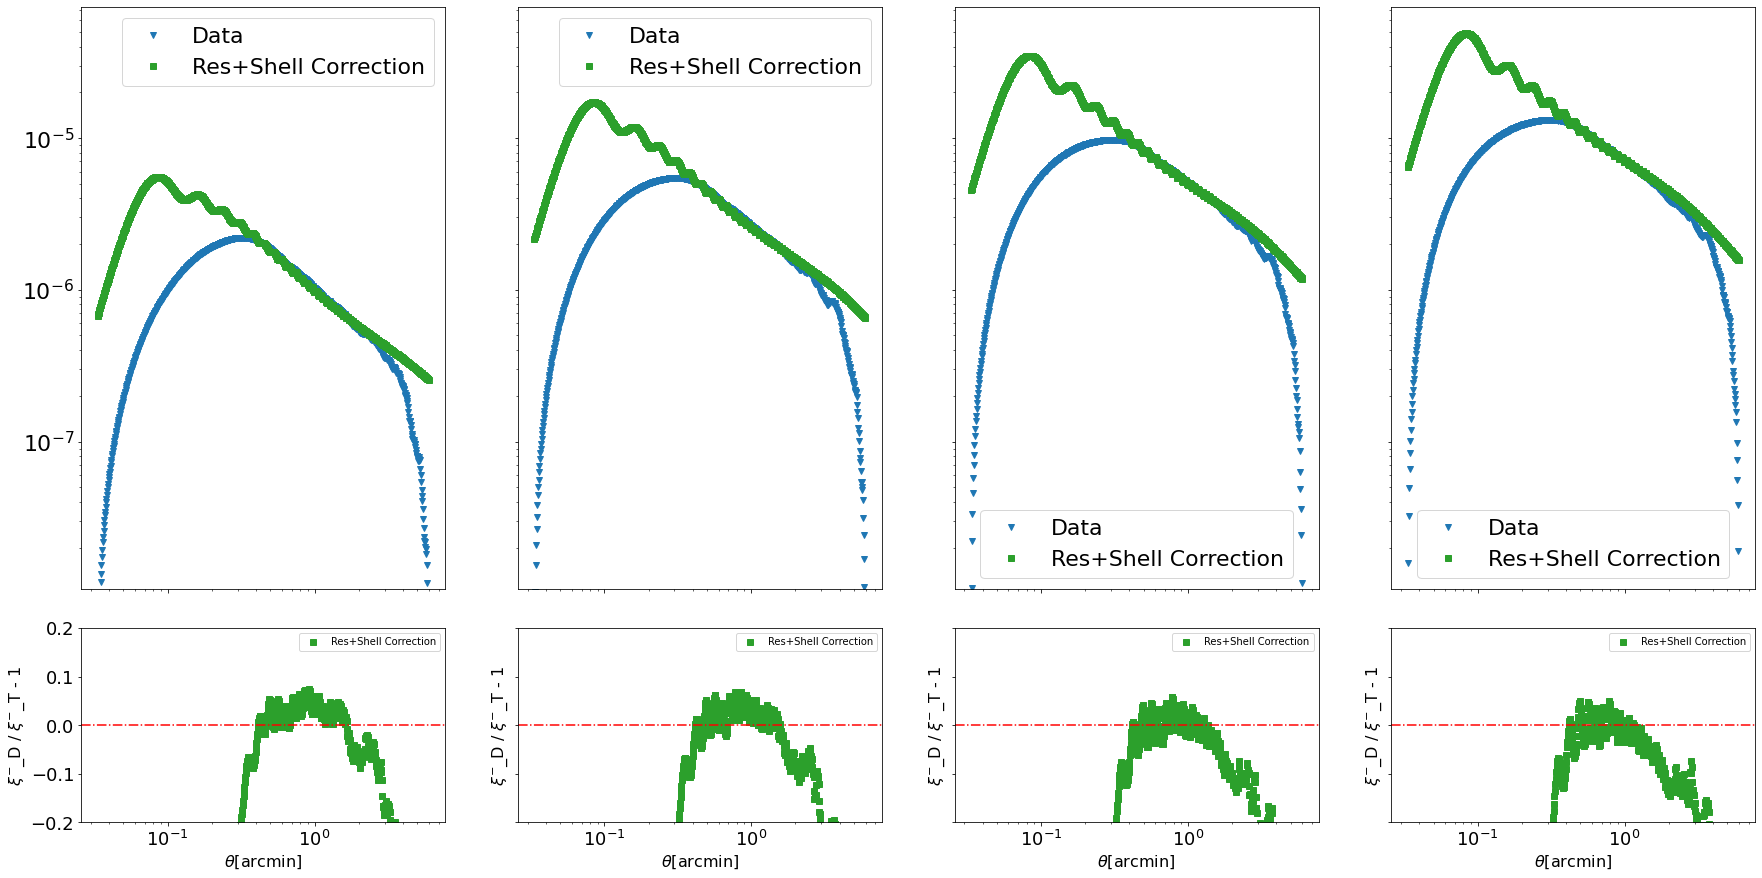

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 15), sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
for i in range(4):
    top, bot = axs[0, i], axs[1, i]
    top.loglog(theta, cf_data_avg[i, :, 1], 'v', label='Data')
    for cf_key in cf_keys:
        top.loglog(theta, cf_avg[cf_key][i, :, 1], cf_dots[cf_key], label=cf_labels[cf_key], color=cf_colors[cf_key])
        bot.semilogx(theta, cf_data_avg[i, :, 1] / cf_avg[cf_key][i, :, 1] - 1, cf_dots[cf_key], label=cf_labels[cf_key], color=cf_colors[cf_key])
        
    top.legend(fontsize=22)
    top.tick_params(axis='both', which='major', labelsize=22)
    top.tick_params(axis='both', which='minor', labelsize=10)
    bot.legend()
    bot.set_xlabel(r'$\theta$[arcmin]', fontsize=16)
    bot.set_ylabel(r'$\xi^{-}$_D / $\xi^{-}$_T - 1', fontsize=16)
    bot.tick_params(axis='both', labelsize=18)
    bot.set_ylim(-0.2, 0.2)
    bot.axhline(0, c='red', ls='-.')

In [39]:
def bin_2d_coupling(
        M=[],
        bin_utils=None,
        wt_b=None,
        wt0=None,
        partial_bin_side=None,
        lm=0,
        lm_step=-1,
        cov=False,
    ):  # asymmetric binning
        ndim = 1
        if cov:
            ndim = 2
        binning_mat = bin_utils["binning_mat"]

        if len(wt0.shape) == 1:
            binning_mat2 = wt0[:, None] * binning_mat * wt_b
        else:
            binning_mat2 = (
                wt0 @ binning_mat @ wt_b
            )  # FIXME: Test this.... doesnot work. not used anymore.

        #         rdr=bin_utils['r_dr']
        #         r_dr_m=bin_utils['r_dr_m'][ndim]
        #         binning_mat=binning_mat*rdr[:,None]/bin_utils['norm'][None,:]

        binning_mat = bin_utils["binning_mat_r_dr"]
        if partial_bin_side is None:
            cov_b = binning_mat.T @ M @ binning_mat2
        elif partial_bin_side == 1:
            cov_b = binning_mat.T @ M @ binning_mat2[lm : lm + lm_step, :]
        elif partial_bin_side == 2:
            cov_b = binning_mat[lm : lm + lm_step, :].T @ M @ binning_mat2

        #         cov_b/=bin_utils['norm_m'][1][:,None]
        return cov_b

def bin_2d_inv_WT(
        wig_mat=[],
        wig_norm=None,
        bin_utils_xi=None,
        bin_utils_cl=None,
        wt_b=None,
        wt0=None,
        use_binned_l=False,
        win_xi=None,
    ):

        wig_mat = wig_mat.T * wig_norm
        if bin_utils_xi is not None:
            binning_mat_xi = bin_utils_xi["binning_mat"]
            if wt_b is None:
                wt_b = bin_utils_xi["wt_b"]
            if wt0 is None:
                wt0 = bin_utils_xi["wt0"]
            if len(wt0.shape) == 1:
                binning_mat_xi2 = wt0[:, None] * binning_mat_xi * wt_b
            else:
                binning_mat_xi2 = wt0 @ binning_mat_xi @ wt_b  # FIXME: Test this.

            wm = wig_mat @ binning_mat_xi2

        else:
            wm = wig_mat

        wig_mat_b = wm
        if bin_utils_cl is not None and use_binned_l:
            bin_mat_cl = bin_utils_cl["binning_mat"]

            rdr = bin_utils_cl["r_dr"]
            bin_mat_cl = bin_mat_cl * rdr[:, None] / bin_utils_cl["norm"][None, :]

            wig_mat_b = bin_mat_cl.T @ wm
        return wig_mat_b

In [40]:
with open('../data/M_2_taper.pickle', 'rb') as f:
    M2p = pickle.load(f)
    
with open('../data/M_-2_taper.pickle', 'rb') as f:
    M2m = pickle.load(f)
    
with open('../data/bu.pickle', 'rb') as f:
    cl_bu = pickle.load(f)

In [46]:
theta = np.loadtxt('../2pcf_800/r000_rot00/cf_0_0.txt')[:, 0]
theta_min = np.min(theta)
theta_max = np.max(theta)
#theta_bins = np.linspace(theta_min, theta_max, 20)
theta_bins = np.logspace(np.log10(theta_min), np.log10(theta_max), 20)
xi_bu = binning()
xi_bu = xi_bu.bin_utils(theta, theta_bins)

In [47]:
corr = corr_ll
WT_kwargs = {
    'l': np.arange(3072), 'l_cut_weights': None, 'theta': theta / 60. * d2r, 's1_s2': s1_s2s[corr],
    'wig_d_taper_order_low': None, 'wid_d_taper_order_high': None
}
WT = wigner_transform(**WT_kwargs)
WT.gather_data()

Scattering WT data 1


In [53]:
s1_s2 = s1_s2s[corr]
cl_ee_sl = np.zeros((N, 4, 10))
cl_bb_sl = np.zeros((N, 4, 10))
cl_ee_binned = np.zeros((N, 4, 10))
cl_bb_binned = np.zeros((N, 4, 10))
for i in tqdm(range(N)):
    file = l[i]
    run, rot = file[13:16], file[20:22]
    run = int(run)
    rot = int(rot)
    for j in range(4):
        cl = np.loadtxt(f'../cl_corrected/r{run:03d}_rot{rot:02d}/cl_{j}_{j}.txt')[:, 1]
        cl_binned = np.dot(cl[:3072] * cl_bu['r_dr'], cl_bu['binning_mat']) / cl_bu['norm']
        wt_b_p = (np.dot(cf_dict['correction'][i][j, :, 0] * xi_bu['r_dr'], xi_bu['binning_mat'])/xi_bu['norm'])
        wt0_p = 1./cf_dict['correction'][i][j, :, 0]
        Hp = bin_2d_inv_WT(wig_mat=WT.wig_d[s1_s2[0]], wig_norm=WT.inv_wig_norm,
                 bin_utils_xi=xi_bu, bin_utils_cl=cl_bu, wt_b=wt_b_p, wt0=wt0_p,
                  use_binned_l=True
                 )
        wt_b_m = (np.dot(cf_dict['correction'][i][j, :, 1] * xi_bu['r_dr'], xi_bu['binning_mat'])/xi_bu['norm'])
        wt0_m = 1./cf_dict['correction'][i][j, :, 1]
        Hm = bin_2d_inv_WT(wig_mat=WT.wig_d[s1_s2[1]], wig_norm=WT.inv_wig_norm,
                 bin_utils_xi=xi_bu, bin_utils_cl=cl_bu, wt_b=wt_b_m, wt0=wt0_m,
                  use_binned_l=True
                 )
        
        xip_bin = np.dot(cf_data[i][j, :, 0] * xi_bu['r_dr'], xi_bu['binning_mat'])/xi_bu['norm']
        xim_bin = np.dot(cf_data[i][j, :, 1] * xi_bu['r_dr'], xi_bu['binning_mat'])/xi_bu['norm']
        Dp = Hp @ xip_bin
        Dm = Hm @ xim_bin

        De = 0.5 * (Dp + Dm)
        Db = 0.5 * (Dp - Dm)

        cl_ee_theory = cl[:3072] * 1.
        cl_bb_theory = cl[:3072] * 0
        cl_ee_t = cl_binned * 1.
        cl_bb_t = cl_binned * 1.
        cl_ee_binned[i][j] = cl_ee_t
        cl_bb_binned[i][j] = cl_bb_t

        wt0_ee = 1. / cl_ee_theory
        wt0_bb = 1. / cl_bb_theory
        wt0_ee[:1] = 0
        wt0_bb[:] = 0

        Mp_ee_binned = bin_2d_coupling(M=M2p, bin_utils=cl_bu, wt_b=cl_ee_t, wt0=wt0_ee)
        Mp_bb_binned = bin_2d_coupling(M=M2p, bin_utils=cl_bu, wt_b=cl_bb_t, wt0=wt0_bb)
        Mm_ee_binned = bin_2d_coupling(M=M2m, bin_utils=cl_bu, wt_b=cl_ee_t, wt0=wt0_ee)
        Mm_bb_binned = bin_2d_coupling(M=M2m, bin_utils=cl_bu, wt_b=cl_bb_t, wt0=wt0_bb)

        cl_ee_sl[i][j] = De @ np.linalg.pinv(Mp_ee_binned) - cl_bb_t @ (np.linalg.pinv(Mp_ee_binned) @ Mm_bb_binned)
        cl_bb_sl[i][j] = Db @ np.linalg.pinv(Mp_bb_binned) - cl_ee_t @ (np.linalg.pinv(Mp_bb_binned) @ Mm_ee_binned)

100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


In [54]:
cl_ee_sl_avg = np.mean(cl_ee_sl, axis=0)
cl_bb_sl_avg = np.mean(cl_bb_sl, axis=0)
cl_ee_binned_avg = np.mean(cl_ee_binned, axis=0)
cl_bb_binned_avg = np.mean(cl_bb_binned, axis=0)

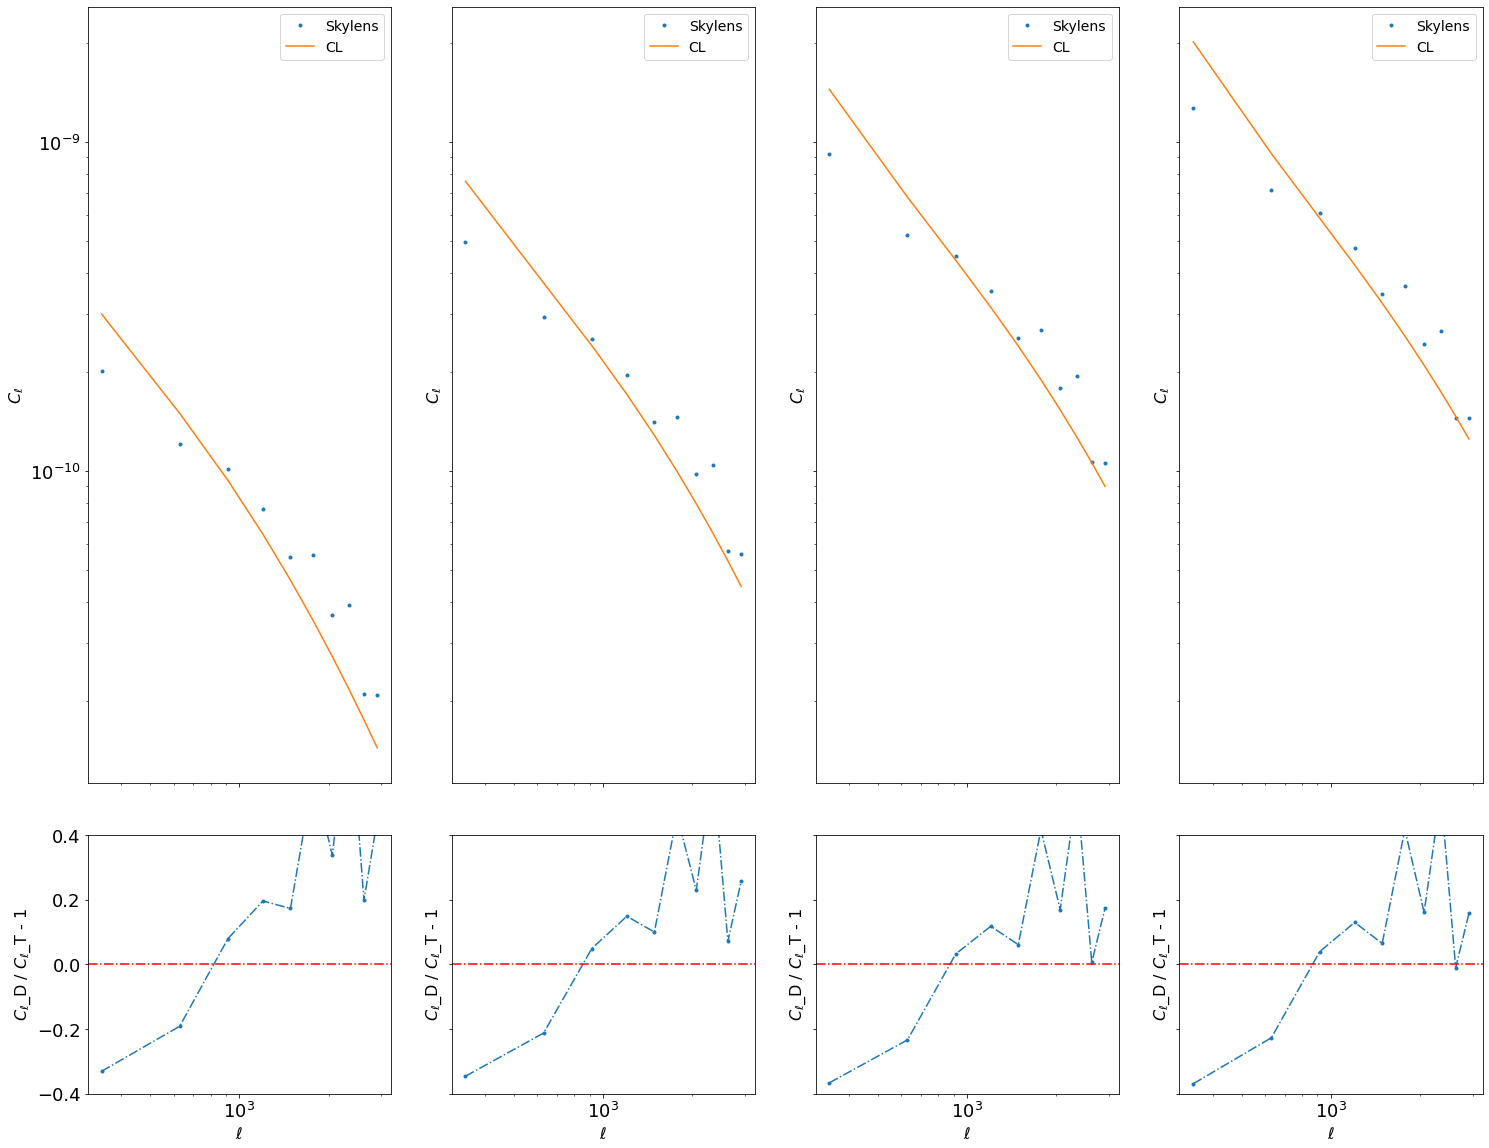

In [55]:
bc = cl_bu['bin_center']
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 20), sharey='row', sharex=True, 
                        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
for i in range(4):
    top, bot = axs[0, i], axs[1, i]
    top.loglog(bc, cl_ee_sl_avg[i], '.', label='Skylens')
    #top.loglog(bc, cl_ee_binned_avg[cl_key][i], label=cl_labels[cl_key], c=cl_colors[cl_key])
    top.loglog(bc, cl_ee_binned_avg[i], label='CL')

    top.set_ylabel(r'$C_\ell$', fontsize=16)
    top.legend(fontsize=14)
    top.tick_params(axis='both', labelsize=18)
    #top.axvspan(3*nside, 5e5, alpha=0.4, color='gray')
    #top.axvspan(1, bc[0], alpha=0.4, color='gray')
    
    bot.semilogx(bc, cl_ee_sl_avg[i] / cl_ee_binned_avg[i] - 1, '.', ls='-.')
        
    #bot.legend(fontsize=14)
    bot.set_xlabel(r'$\ell$', fontsize=16)
    bot.set_ylabel(r'$C_\ell$_D / $C_\ell$_T - 1', fontsize=16)
    bot.tick_params(axis='both', labelsize=18)
    bot.set_ylim(-.4,.4)
    bot.axhline(0, c='red', ls='-.')

Get D^{+/-} = H^-1 * Xi^{+/-}
Define D^EE/BB = (D^+ +/- D^-)